In [157]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine, MetaData, Table, Column, ForeignKey, String, Integer, Float, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
import numpy as np
import matplotlib.pyplot as plt


In [158]:
#https://www.sqlitetutorial.net/sqlite-python/creating-tables/
# Methods to handle database
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn
    


def load_csv_to_db(conn,csv_filename,table_name):
    df = pd.read_csv(csv_filename)
    df.to_sql(table_name, conn, if_exists='append', index = False)



In [159]:
Base = declarative_base()

# Sqlalchemy Tables:
class Ratings(Base):
    __tablename__ = "Ratings"
    ratingId = Column("ratingId", Integer, primary_key=True)
    userId = Column("userId", Integer)
    movieId =Column(Integer, ForeignKey("Movies.movieId"),index=True)
    rating = Column("rating", Float)
    timestamp = Column("timestamp", DateTime)

    def __init__(self, userId,movieId,rating,timestamp):
        self.userId = userId
        self.movieId = movieId
        self.rating = rating
        self.timestamp = timestamp
    def __repr__(self):
        return f"{self.userId}, {self.movieId}, {self.rating}"


class Movies(Base):
    __tablename__ = "Movies"
    movieId = Column("movieId", Integer, primary_key=True,index=True)
    title = Column("title", String)
    genres =Column("genres", String)

    def __init__(self, movieId, title, genre):
        self.movieId = movieId
        self.title = title
        self.genre =genre
    def __repr__(self):
        return f"{self.movieId}, {self.title}, {self.genre}"






In [4]:
df_ratings = pd.read_csv("movielens/ratings.csv")
df_movies = pd.read_csv("movielens/movies.csv")

In [141]:
join = pd.merge(df_movies["movieId"], df_ratings[["movieId", "rating"]], on='movieId', how='outer').groupby(['movieId'])
results_df = join["movieId"].all()
num_of_ratings = np.array(join.count()["rating"])
avg_of_ratings = np.array(join.mean()["rating"])
sum_of_ratings = np.array(join.sum("rating")["rating"])
total_num_of_ratings = num_of_ratings.sum()
num_of_movies = sum_of_ratings.shape[0]

In [155]:
def calculate_rating(sum_of_ratings_i, num_of_ratings_i, total_num_of_ratings, num_of_movies):
    avg_number_of_ratings = total_num_of_ratings/ num_of_movies
    if num_of_ratings_i<1:
        return 0
    penalty=(num_of_ratings_i-avg_number_of_ratings)/(avg_number_of_ratings)
    penalty = np.clip(penalty, -1, 0)
    return (sum_of_ratings_i/num_of_ratings_i)  + penalty 

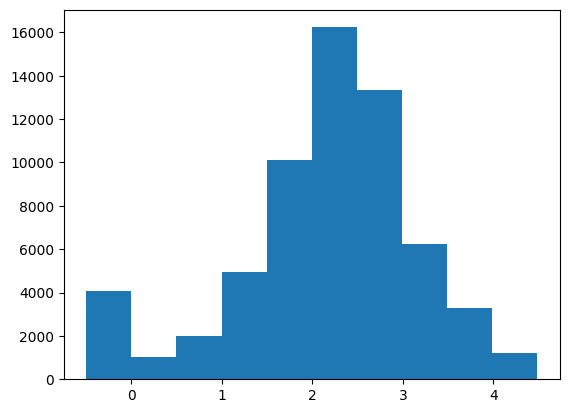

In [156]:
avg_of_rating = np.zeros(num_of_movies)
for i in range (num_of_movies):
    avg_of_rating[i] = calculate_rating(sum_of_ratings[i], num_of_ratings[i], total_num_of_ratings, num_of_movies)
#plt.plot(avg_of_rating, ".")
plt.hist(avg_of_rating,bins=10)
plt.show()

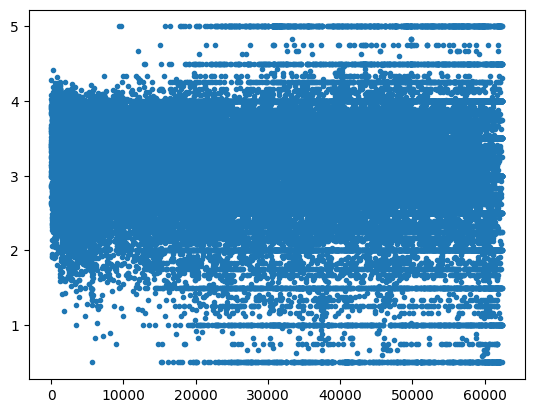

In [64]:
plt.plot(avg_of_ratings,".")

In [160]:

engine = create_engine("sqlite:///Database/movielens.db")
Base.metadata.create_all(bind=engine)

In [161]:
#connect to database and import als csv files as tables
from sqlalchemy.types import Integer, String, DateTime
connection=create_connection("Database/movielens.db")
#load_csv_to_db(connection, "movielens/tags.csv", "Tags")
load_csv_to_db(connection, "movielens/movies.csv","Movies")
load_csv_to_db(connection, "movielens/ratings.csv", "Ratings")

#load_csv_to_db(connection, "movielens/genome-scores.csv", "Genome_Scores")
#load_csv_to_db(connection, "movielens/genome-tags.csv", "Genome_Tags")
#load_csv_to_db(connection, "movielens/links.csv", "Links")



2.6.0


In [6]:
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='index';"""
cursor = connection.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())

[('Movies',), ('Ratings',)]


In [9]:
db = connection.cursor()
rows = db.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
tables = [row[0] for row in rows]

def sql_identifier(s):
    return '"' + s.replace('"', '""') + '"'

for table in tables:
    print("table: " + table)
    rows = db.execute("PRAGMA table_info({})".format(sql_identifier(table)))
    print(rows.fetchall())
    rows = db.execute("PRAGMA foreign_key_list({})".format(sql_identifier(table)))
    print(rows.fetchall())

table: Movies
[(0, 'movieId', 'INTEGER', 1, None, 1), (1, 'title', 'VARCHAR', 0, None, 0), (2, 'genres', 'VARCHAR', 0, None, 0)]
[]
table: Ratings
[(0, 'ratingId', 'INTEGER', 1, None, 1), (1, 'userId', 'INTEGER', 0, None, 0), (2, 'movieId', 'INTEGER', 0, None, 0), (3, 'rating', 'FLOAT', 0, None, 0), (4, 'timestamp', 'DATETIME', 0, None, 0)]
[(0, 0, 'Movies', 'movieId', 'movieId', 'NO ACTION', 'NO ACTION', 'NONE')]


In [10]:
session.query(Movie)

In [ ]:
class Tag(Base):
    __tablename__ = "Tags"
    userId = Column("userId", Integer)
    tagId = Column("tagId", Integer, primary_key=True)
    movieId = Column(Integer, ForeignKey("Movies.movieId"))
    tag = Column("tag", String)
    timestamp = Column("timestamp", DateTime)
    def __init__(self, tagId, movieId, tag,timestamp, userId):
        self.movieId = movieId
        self.tagId = tagId
        self.tag =tag
        self.timestamp = timestamp
        self.userId = userId
    def __repr__(self):
        return f"{self.tag}, {self.movieId}"

class Score(Base):
    __tablename__ = "Genome_Scores"
    scoreId = Column("scoreId", Integer, primary_key=True)
    movieId = Column(Integer, ForeignKey("Movies.movieId"))
    tagId = Column("tagId", Integer)
    relevance = Column("relevance", Float)
    def __init__(self, tagId, movieId, scoreId,relevance):
        self.movieId = movieId
        self.tagId = tagId
        self.scoreId =scoreId
        self.relevance = relevance
    def __repr__(self):
        return f"{self.movieId}, {self.scoreId}, {self.relevance}"

class Genome_Tag(Base):
    __tablename__ = "Genome_Tags"
    tagId = Column( "tagId",Integer, primary_key=True)
    tag = Column("tag", String)
    def __init__(self, tagId, tag):
        self.tagId = tagId
        self.tag = tag
    def __repr__(self):
        return f"{self.tag}"

class Link(Base):
    __tablename__ = "Links"
    linkId = Column("linkId", Integer, primary_key=True)
    movieId = Column(Integer, ForeignKey("Movies.movieId"))
    imdbId = Column("imdbId", Integer)
    tmdbId = Column("tmdbId", Float)
    def __init__(self, imdbId, movieId, tmdbId,relevance):
        self.movieId = movieId
        self.imdbId = imdbId
        self.tmdbId =tmdbId
    def __repr__(self):
        return f"{self.movieId}, {self.imdbId}, {self.tmdbId}"


In [ ]:

metadata_obj = MetaData()
Ratings = Table(
    "Ratings",
    metadata_obj,
    Column("ratingId", Integer, primary_key=True, index=True),
    Column("userId", Integer),
    Column("movieId",Integer, ForeignKey("Movies.movieId")),
    Column("rating", Float),
    Column("timestamp", DateTime),
)

Movies = Table(
    "Movies",
    metadata_obj,
    Column("movieId", Integer, primary_key=True, index=True),
    Column("title", String),
    Column("genres", String)
)
engine = create_engine("sqlite:///Database/movielens.db")
metadata_obj.create_all(bind=engine)
